In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!unzip "/content/drive/My Drive/image-detect.zip"

Streaming output truncated to the last 5000 lines.
  inflating: val/images/val_5501.JPEG  
  inflating: val/images/val_5502.JPEG  
  inflating: val/images/val_5503.JPEG  
  inflating: val/images/val_5504.JPEG  
  inflating: val/images/val_5505.JPEG  
  inflating: val/images/val_5506.JPEG  
  inflating: val/images/val_5507.JPEG  
  inflating: val/images/val_5508.JPEG  
  inflating: val/images/val_5509.JPEG  
  inflating: val/images/val_551.JPEG  
  inflating: val/images/val_5510.JPEG  
  inflating: val/images/val_5511.JPEG  
  inflating: val/images/val_5512.JPEG  
  inflating: val/images/val_5513.JPEG  
  inflating: val/images/val_5514.JPEG  
  inflating: val/images/val_5515.JPEG  
  inflating: val/images/val_5516.JPEG  
  inflating: val/images/val_5517.JPEG  
  inflating: val/images/val_5518.JPEG  
  inflating: val/images/val_5519.JPEG  
  inflating: val/images/val_552.JPEG  
  inflating: val/images/val_5520.JPEG  
  inflating: val/images/val_5521.JPEG  
  inflating: val/images/val_552

In [21]:
pip install livelossplot

In [22]:
import torch, torchvision
import torch.nn as nn
import cv2, os
import time, copy, glob, sys, numpy as np, pandas as pd
import tensorflow.keras as keras
from skimage import io
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
from PIL import Image
from shutil import move
import glob
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision.models as models
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

In [4]:
val_dic = {}
f = open("/content/val/val_annotations.txt", "r")
for line in f.readlines():
  l = line.split('\t')
  val_dic[l[0]] = l[1]

path = glob.glob("/content/val/images/*")
for p in path:
  file = p.split("/")[-1]
  folder = val_dic[file]
  if not os.path.exists("/content/val/" + str(folder)):
        os.mkdir("/content/val/" + str(folder)) 

for p in path:
  file = p.split("/")[-1]
  folder = val_dic[file]
  dest = "/content/val/" + str(folder) + '/' + str(file)
  move(p, dest)


In [5]:
f.close()
os.rmdir('/content/val/images')
os.remove("/content/val/val_annotations.txt")

In [6]:
len(os.listdir("/content/val"))

200

In [7]:
data_transform = transforms.Compose([transforms.Resize((224,224), 3), transforms.ToTensor()])

In [8]:
valid_dataset = ImageFolder(root = "/content/val", transform= data_transform )

train_dataset = ImageFolder(root = "/content/train", transform=data_transform)

image_dataset = {
    'train': train_dataset,
    'valid': valid_dataset
}

dataloaders = {x: torch.utils.data.DataLoader(image_dataset[x], batch_size=100, shuffle=True, num_workers=32)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_dataset[x]) for x in ['train', 'valid']}

In [9]:
class_id_map = train_dataset.class_to_idx

In [10]:
class_list = train_dataset.classes

In [ ]:
train_dataset.class_to_idx

In [14]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
model.avgpool =nn.AdaptiveAvgPool2d(1)
fltrs = model.fc.in_features
model.fc = nn.Linear(fltrs, 200)
criterion = nn.CrossEntropyLoss()
optimizer= torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

**The weight after second epoch is loaded into the model**

I will send you the weight file seperatly if you want. let tme know

In [38]:
model.load_state_dict(torch.load("/content/drive/My Drive/Resnet/resnet18_224_w(8).pt"))

<All keys matched successfully>

In [11]:
torch.cuda.is_available()

True

In [39]:

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    since = time.time()
    liveloss = PlotLosses()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i,(inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                print("\rIteration: {}/{}, Loss: {}.".format(i+1, len(dataloaders[phase]), loss.item() * inputs.size(0)),  end="")

                print( (i+1)*100. / len(dataloaders[phase]), "% Complete" )
                sys.stdout.flush()
                
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                avg_loss = epoch_loss
                t_acc = epoch_acc
            else:
                val_loss = epoch_loss
                val_acc = epoch_acc
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                 phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
        liveloss.update({
            'log loss': avg_loss,
            'val_log loss': val_loss,
            'accuracy': t_acc,
            'val_accuracy': val_acc
        })
                
        liveloss.draw()
        print('Train Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, t_acc))
        print(  'Val Loss: {:.4f} Acc: {:.4f}'.format(val_loss, val_acc))
        print('Best Val Accuracy: {}'.format(best_acc))
        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), "/content/drive/My Drive/Resnet/resnet18_224_w(15).pt")
    #torch.save(model, "/content/files/resnet18_224_f(8).pt")
    return model


**Dont run this untill you want to train**

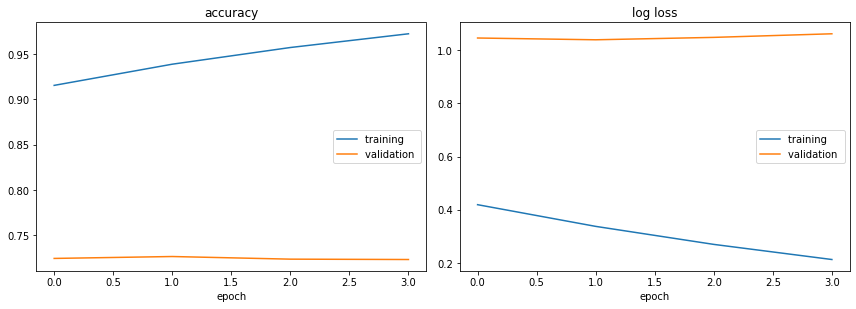

accuracy
	training         	 (min:    0.915, max:    0.972, cur:    0.972)
	validation       	 (min:    0.723, max:    0.727, cur:    0.723)
log loss
	training         	 (min:    0.213, max:    0.419, cur:    0.213)
	validation       	 (min:    1.039, max:    1.062, cur:    1.062)
Train Loss: 0.2126 Acc: 0.9722
Val Loss: 1.0616 Acc: 0.7233
Best Val Accuracy: 0.7266

Epoch 5/7
----------
Iteration: 1/900, Loss: 18.63369047641754.0.1111111111111111 % Complete
Iteration: 2/900, Loss: 13.523444533348083.0.2222222222222222 % Complete
Iteration: 3/900, Loss: 14.217337965965271.0.3333333333333333 % Complete
Iteration: 4/900, Loss: 19.118548929691315.0.4444444444444444 % Complete
Iteration: 5/900, Loss: 18.727275729179382.0.5555555555555556 % Complete
Iteration: 6/900, Loss: 15.68051278591156.0.6666666666666666 % Complete
Iteration: 7/900, Loss: 10.590507835149765.0.7777777777777778 % Complete
Iteration: 8/900, Loss: 19.945010542869568.0.8888888888888888 % Complete
Iteration: 9/900, Loss: 16.0

In [ ]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = train_model(model, dataloaders, dataset_sizes, criterion, optimizer, exp_lr_scheduler, num_epochs=7)

Next steps determine the classes for test images

In [30]:
preprocess = transforms.Compose([transforms.Resize((224,224), 3), transforms.ToTensor()])
path = glob.glob("/content/test/images/*")
result = {}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
c=0
for p in path:
 
  img = p.split('/')[-1]
  image = Image.open(p)
  image_tensor = preprocess(image)
  
  
  if image_tensor.shape == (1,224,224):
    c += 1
    img_tensr = torch.zeros([3,224,224])
    img_tensr[0,:,:] = image_tensor
    img_tensr[1,:,:] = image_tensor
    img_tensr[2,:,:] = image_tensor
    image_tensor = img_tensr
  
  image_batch = image_tensor.unsqueeze(0).to(device)
 
  output = torch.nn.functional.softmax(model(image_batch))
  _, predicted = torch.max(output, 1)
  result[img] = [class_list[predicted]]
 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [31]:
f = open("result.txt", "w")

for k in result:
  f.write(f"{k},{result[k]}\n")
f.close()

In [32]:
df = pd.read_csv("/content/result.txt",names=["file_name", "category"] )

In [33]:
df

,file_name,category
0,test_8954.JPEG,['n04560804']
1,test_2477.JPEG,['n02509815']
2,test_1098.JPEG,['n03424325']
3,test_5667.JPEG,['n03983396']
4,test_1367.JPEG,['n03838899']
...,...,...
9995,test_932.JPEG,['n01944390']
9996,test_3968.JPEG,['n02058221']
9997,test_7566.JPEG,['n04074963']
9998,test_7089.JPEG,['n02125311']


In [35]:
df["category"].value_counts()


['n07614500']    72
['n09256479']    65
['n02977058']    63
['n02769748']    63
['n04399382']    62
                 ..
['n04023962']    37
['n04008634']    36
['n01984695']    36
['n02906734']    34
['n03670208']    34
Name: category, Length: 200, dtype: int64

In [36]:
for i in range(10000):
  df["category"][i] = df["category"][i][2:-2]

In [37]:
df.to_csv("/content/result.csv")